## Меры качества алгоритмов распознавания изображений

Task statement: оценка алгоритмов распознавания образов с помощью интуитивно понятных и объясняемых метрик.

Для каждой задачи (классификация, регрессия, детекция и проч.) определяется своя метрика качества работы алгоритма. Пример:
- Классификация:
    - Доля правильно распознаных ответов (accuracy)
    - Точность (precision)
    - Полнота (recall)
    - Средняя точность (AP)
- Регрессия:
    - Средняя абсолютная ошибка (MAE)
    - Коэффициент детерминации ($R^2$)
    - Cредняя абсолютная процентная ошибка (MAPE)
- Детекция:
    - Коэффициент Жаккара (IoU)
    - mAP
- Трекинг:
    - MOTA
    - HOTA
    
Хороший обзор на базовые метрики классификации и регрессии от Евгения Соколова (ВШЭ) можно найти [тут](http://www.machinelearning.ru/wiki/images/1/1c/sem06_metrics.pdf).

### Классификация

In [3]:
%%bash

wget \
    https://raw.githubusercontent.com/avbokovoy/MIPT-Computer_vision-2020/master/7-Metrics/homework/classification_results.txt \
    -O classification_results.txt \
    -q

In [11]:
import pandas as pd
import sklearn
import numpy as np

In [19]:
df = pd.read_csv(
    filepath_or_buffer='classification_results.txt',
    sep=' ',
    names=['actual','predicted'],
)
print('Actual classes:', sorted(df['actual'].unique()))

Actual classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<!--
{| border="0" align="center" style="text-align: center; background: #FFFFFF;"
|+
!
! colspan="2" style="background: #ddffdd;"|actual class <br/> (observation)
|-
!
|-----
|+
! rowspan="2" style="background: #ffdddd;"|predicted class <br/> (expectation)
| '''tp''' <br /> (true positive) <br/> Correct result
| '''fp''' <br /> (false positive) <br/> Unexpected result
|-bgcolor="#EFEFEF"
| '''fn''' <br /> (false negative) <br/> Missing result
| '''tn''' <br /> (true negative) <br/> Correct absence of result
|+
|}

-->

### Бинарная классификация

Матрица ошибок (confusion matrix)

|          | y = 1 | y = 0 |
|    ---   |  ---  |  ---  |
| a(x) = 1 | Истинно положительный (TP)| Ложно-положительный (FP)|
| a(x) = 0 | Ложно-отрицательный (FN)  | Истинно-отрицательный (TN)|

Метрики:
- Accuracy = $\frac{TP + FN}{TP + FN + FP + FN}$
- Precision = $\frac{TP}{TP + FP}$
- Recall = $\frac{TP}{TP + FN}$

### Многоклассовая классификация

Матрица ошибок (confusion matrix) для 3 классов (пример)

|          | y = 2 | y = 1 | y = 0 |
|    ---   |  ---  |  ---  |  ---  |
| a(x) = 2 | $a_{1,1}$ | $a_{1,2}$ | $a_{1,3}$ |
| a(x) = 1 | $a_{2,1}$ | $a_{2,2}$ | $a_{2,3}$ |
| a(x) = 0 | $a_{3,1}$ | $a_{3,2}$ | $a_{3,3}$ |

Например, расчет для класса 2:
- TP: $a_{1,1}$
- FP: $a_{1,2} + a_{1,3}$
- FN: $a_{2,1} + a_{3,1}$
- TN: неопределен

Среднее по классам: `micro` и `macro`, `weighted`
- micro: суммирование всех TP, FP, FN в классах и вычисление финальной метрики
- macro: вычисление метрики в каждом классе и взятие взвешенной суммы (вес каждого - 1 / кол-во классов)
- weighted: вычисление метрики в каждом классе и взятие взвешенной суммы (вес каждого - кол-во элементов в классе / кол-во элементов всего)

Вопрос 1. Составьте confusion matrix и посчитайте приведенные метрики на скаченном наборе данных. Сравните их со стандартными реализациями в `sklearn.metrics`.

In [ ]:
#TODO

Вопрос 2. Хороша ли метрика accuracy в мульклассовой классификациии? Почему?

In [10]:
#TODO

### Дополнительная глава. Построение кривых уверенности.

1. ROC кривая. Можно почитать [тут](https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/). Как следствие - ROC-AUC метрика для классификации. Проблема - чувсвительность к дисбалансу классов.
2. PR кривая. Алгоритм построения кривой указан [тут](http://www.machinelearning.ru/wiki/images/1/1c/sem06_metrics.pdf) на странице 8. Как следствие - метрика AP.

Дополнительную информацию о взаимоотношениях между ROC и PR кривой можно почитать [тут](https://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf).

In [39]:
#сводим мультиклассовую задачу к одноклассовой с помощью клиппинга

zero_one_class_mask = (df['actual'] == 0) | (df['actual'] == 1)

y_true = df['actual'][zero_one_class_mask]
y_pred = df['predicted'][zero_one_class_mask]

#set clipped scores
probas = y_pred.clip(0, 1)

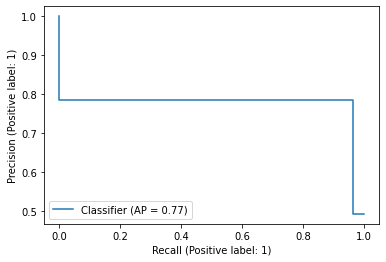

In [40]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_true, probas)

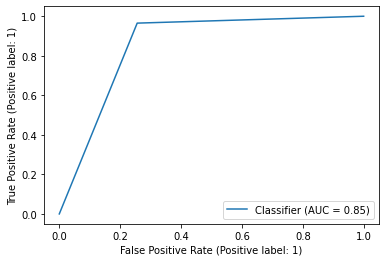

In [41]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_true, probas)

### Детекция

Задача подсчета качества детекции сводится к подсчету классификации с помощью введения метрики схожести. Зачастую для сопоставления объектов берется метрика Intersection Over Union (IoU).

$IoU(A, B) = \frac{|A \cup B|}{|A \cap B|}$

Объекты для сравнения могут выступать в виде 2D/3D ограничивающих рамок или масок сегментации.

![text](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61e9cff8038fd36e52c7a192_HeKufHa.png)

Ограничивающий прямоугольник 2D может быть определен, используя всего 4 числа:
- координаты диагональных углов (xyxy)
- координаты центра и ширины, и длины (xywh)

Ограничивающий прямоугольник 3D может быть определен, используя всего 6 чисел:
- координаты центра (xyz), длина, ширина, высота (lhw), угол поворота ($\theta$)

Маска сегментации определяется через бинарную маску с размерами, равными исходному изображению.

![text](https://www.researchgate.net/publication/335876570/figure/fig2/AS:804291526795265@1568769451765/Intersection-over-Union-IOU-calculation-diagram.png)

In [45]:
# Вопрос 3. Реализуйте метрику IoU для ограничивающих 2D рамок.

'''
    0,0 ------> x (width)
     |
     |  (Left,Top)
     |      *_________
     |      |         |
     v      |         |
     y      |_________|
  (height)            *
                (Right,Bottom)
'''

def bb_iou(
    boxA: list[int],
    boxB: list[int],
) -> float:
    
    '''
    Intersection Over Union
    Inputs:
    boxA:  list[int], corner up left, corner down right.
    boxB:  list[int], corner up left, corner down right.
    
    Outputs:
    iou: float, Intersection Over Union
    '''
    
    #TODO
    
	return iou

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-45-c8b55f60b2ea>, line 19)

In [10]:
# tests
questions = [
    [[39, 63, 203, 112], [54, 66, 198, 114]],
    [[39, 63, 203, 112], [90, 63, 203, 112]],
    [[39, 63, 203, 112], [39, 63, 203, 112]],
    [[0, 0, 0, 0], [39, 63, 203, 112]],
]
answers = [
    0.798,
    0.691,
    1.,
    0.,
]

for question, answer in zip(questions, answers):
    
    first, second = question
    
    algo_out = bb_iou(first, second)
    
    assert np.allclose(
        a=answer,
        b=algo_out,
        rtol=1e-02,
    ), f'Test with {first} and {second} bboxes was filed. Got {algo_out}, expected {answer}.'
    
print('All done!')

All done!


Как вычислить метрику для результатов детекции? Прежде чем приступить к подсчету метрики, определимся с понятием объекта. Объект состоит из его характеристик локализации (2D/3D рамки, либо маски сегментации), класса объекта и уверенности в предсказании.

В общей постановке задачи, алгоритм выдает N объектов, а в нашей разметке содержится M объектов. Как же посчитать метрику качества?

Основная пробелема - матчинг объектов.

![test](https://manalelaidouni.github.io/assets/img/pexels/Detections_IoU_edit1-401ab064-29c4-4e74-8b34-b79b7b5cb6eb.png)

Основные шаги:
- определение трешхолда IoU (tr_iou). Если объект имеет тот же класс и IoU между предсказанной локализацией и  правильной локализацией. Если IoU >= tr_iou и совпадает класс, объект считатся TP, иначе FP.
- Необходимо найти лучший матчинг, для этого в первоначальном приближении используется Жадный алгоритм (поиск максимума по IoU), оптимальный алгоритм - Венгерский.
- непокрытые объекты в разметке помечаются как FN

Библиотеки, которые могу вести подсчет AP:
- https://github.com/rafaelpadilla/Object-Detection-Metrics
- https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools
- и другие.


In [2]:
#download segmentation results

%pip install -U --no-cache-dir gdown --pre
%pip install -U pycocotools

#predicted
!gdown \
    --id 10YDnKAzf-zsE0IguEyZh__QNwgJD7l2H \
    --fuzzy \
    -O epoch_30_test_00_00.segm.json
    
#ground truth
!gdown \
    --id 1pwyerjxRcHOEvjahMDPy3pjZuYSHLvZN \
    --fuzzy \
    -O test_00_00_instances.json

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=860878d89f2a30cfc8410fe38c095bb03cb949c770e7fbe15a8e03874014c884
  Stored in directory: /private/var/folders/43/vchb6g294j5847xg1vmhgk1c0000gn/T/pip-ephem-wheel-cache-h1p55aym/wheels/7d/37/b6/b2a79c75e898c0b8e46ff255102602d7159a10d9af0d80641a
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.0
    Uninstalling gdown-4.2.0:
      Successfully uninstalled gdown-4.2.0
Note: you may need to restart the kernel to use updated packages.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/

In [4]:
!python3 detection_metrics.py

loading annotations into memory...
Done (t=6.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=20.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=239.52s).
Accumulating evaluation results...
DONE (t=31.30s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

### Трекинг объектов (Multiple Object Tracing, MOT)

Требуется отслеживать несколько объектов. Ожидается, что алгоритм отслеживания, во-первых, определит количество объектов в каждом кадре, а во-вторых, будет отслеживать идентификацию каждого объекта от одного кадра к следующему.

Трекинг - сложная проблема: переключения идентификаторов трудно избежать, особенно в переполненных видео, а также количество объектов в каждом кадре неизвестны, поэтому алгоритмы MOT сильно полагаются на алгоритмы обнаружения, которые сами по себе не идеальны. Существует множество метрик для отслеживания качества предсказаний трекинга объектов.

- 2D detection: MOTA, MOTP: [paper](https://cvhci.anthropomatik.kit.edu/~stiefel/papers/ECCV2006WorkshopCameraReady.pdf), [code](https://github.com/JonathonLuiten/TrackEval)
- Segmentation: MOTSA: [paper](https://arxiv.org/pdf/1902.03604.pdf), [code](https://github.com/VisualComputingInstitute/mots_tools)
- 2D/3D/Segmentation HOTA: [paper](https://arxiv.org/abs/2009.07736), [code](https://github.com/JonathonLuiten/TrackEval)

![text](https://miro.medium.com/max/896/1*ak-WaHg4bi3al2qc1bv9NA.png)

где $FN_t$ - количество ложно-отрицательных срабатываний (пропущенных объектов), $FP_t$ - количество ложных-положительных срабатываний (лишних траекторий объектов), $IDS_t$ - количество переключений идентификаторов в момент времени t. Цель считается пропущенной, если IoU (pred, true) < iou_tr. Обратите внимание, что MOTA может быть отрицательным.